# Prototyping
Prototype what the package might look like.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from scipy.interpolate import splev
import astropy.units as u
from astropy.coordinates import SkyCoord
import astropy.wcs
from astropy.time import Time
import sunpy.map
import hissw

from synthesizAR.maps import EMCube
from synthesizAR.instruments import InstrumentSDOAIA

%matplotlib inline

Setup some basic parameters that will be useful to all models

In [2]:
aia = InstrumentSDOAIA([0,1]*u.s,None)

In [3]:
temperature_bin_edges = 10.**np.arange(5.0,7.0,0.2) * u.K
temperature_bin_centers = (temperature_bin_edges[1:] + temperature_bin_edges[:-1])/2.

In [4]:
responses = [splev(temperature_bin_centers.value, c['temperature_response_spline']) for c in aia.channels]

In [5]:
filenames = ['/Users/willbarnes/sunpy/data/cutouts/aia_lev1.5_20110212T120002_94_cutout.fits',
             '/Users/willbarnes/sunpy/data/cutouts/aia_lev1.5_20110212T120009_131_cutout.fits',
             '/Users/willbarnes/sunpy/data/cutouts/aia_lev1.5_20110212T120012_171_cutout.fits',
             '/Users/willbarnes/sunpy/data/cutouts/aia_lev1.5_20110212T120007_193_cutout.fits',
             '/Users/willbarnes/sunpy/data/cutouts/aia_lev1.5_20110212T120000_211_cutout.fits',
             '/Users/willbarnes/sunpy/data/cutouts/aia_lev1.5_20110212T120003_335_cutout.fits']

In [6]:
maps = [sunpy.map.Map(f) for f in filenames]

/Users/willbarnes/anaconda/envs/synthesized-timelags/lib/python3.6/site-packages/sunpy/map/sources/sdo.py:48: SunpyDeprecationWarning: Use Matplotlib to load the colormaps
  self.plot_settings['cmap'] = cm.get_cmap(self._get_cmap_name())


## Model Infrastructure

In [7]:
class GenericModel(object):
    
    @u.quantity_input
    def __init__(self, maps, temperature: u.K, responses, **kwargs):
        self.temperature = temperature
        wvl = u.Quantity([m.meta['wavelnth']*u.Unit(m.meta['waveunit']) for m in maps])
        self.maps = [maps[i] for i in np.argsort(wvl)]
        self.response = [responses[i] for i in np.argsort(wvl)]
        self.wavelength = np.sort(wvl)
        
    def fit(self,):
        pass

In [8]:
class IDLModel(GenericModel):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args,**kwargs)
        if 'dem_path' not in kwargs:
            raise ValueError('Must specify path to DEM IDL code')
        self.ssw = hissw.ScriptMaker(ssw_packages=self.ssw_packages,ssw_paths=self.ssw_paths,
                                     extra_paths=[kwargs.get('dem_path')])
        self.mapcube = np.stack([m.data for m in self.maps],axis=2)
        self.response_matrix = np.stack(self.response)
        
    def _fit(self, **kwargs):
        input_args = self.input_args
        input_args.update(kwargs)
        return self.ssw.run(self._template, args=input_args, save_vars=self.save_vars,
                            verbose=True,cleanup=False)
    
    def to_emcube(self, em):
        header = self.maps[0].meta.copy()
        del header['telescop']
        del header['detector']
        del header['waveunit']
        del header['instrume']
        del header['wavelnth']
        return EMCube(em,header,self.temperature,
                      plot_settings={'cmap':'magma','norm':matplotlib.colors.SymLogNorm(1,vmin=1e25,vmax=1e30)})
    

## Hannah and Kontar Regularized Model

In [9]:
class HannahKontarModel(IDLModel):
    
    @property
    def ssw_packages(self,):
        return ['sdo/aia']
    
    @property
    def ssw_paths(self,):
        return ['aia','xrt']
    
    @property
    def input_args(self,):
        return {
            'log_temperature': np.log10(((self.temperature[1:] + self.temperature[:-1])/2.).to(u.K).value).tolist(),
            'temperature_bin_edges': self.temperature.to(u.K).value.tolist(),
            'saturation_level': 2e4,
            'edge_trim': 10,
            'aia_error_table_filename': os.path.join(self.ssw.ssw_home, 'sdo/aia/response/aia_V2_error_table.txt'),
            'n_sample': 1,
            'maps': self.mapcube.T.tolist(),
            'response_matrix': self.response_matrix.tolist(),
        }
    
    @property
    def save_vars(self,):
        return ['dem', 'dem_errors', 'logt_errors', 'chi_squared', 'dn_regularized']
    
    def fit(self,**kwargs):
        self.results = self._fit(**kwargs)
        em = np.transpose(self.results['dem'],axes=(2,1,0))/(u.cm**5)/u.K
        em = em*np.diff(self.temperature)
        return self.to_emcube(em)
    
    @property
    def _template(self,):
        return """
        data = {{maps}}
        print,size(data)
        ; Set some basic parameters
        nx=n_elements(data[*,0,0])
        ny=n_elements(data[0,*,0])
        nchannels=n_elements(data[0,0,*])

        ; Filter out bad pixels
        sat_lvl={{ saturation_level }}
        id=where(data ge sat_lvl,nid)
        if (nid gt 1) then data[id]=0.0
        id=where(data le 0,nid)
        if (nid gt 1) then data[id]=0.0
        edg0={{edge_trim}}
        data[0:edg0-1,*,*]=0.0
        data[*,0:edg0-1,*]=0.0
        data[nx-edg0:nx-1,*,*]=0.0
        data[*,ny-edg0:ny-1,*]=0.0

        ; Calculate errors
        data_errors=fltarr(nx,ny,nchannels)
        channels = [94,131,171,193,211,335]
        common aia_bp_error_common,common_errtable
        common_errtable=aia_bp_read_error_table('{{ aia_error_table_filename }}')
        for i=0,nchannels-1 do data_errors[*,*,i]=aia_bp_estimate_error(reform(data[*,*,i]),replicate(channels[i],nx,ny),n_sample={{ n_sample }})

        ; Get temperature bins
        response_logt = {{log_temperature}}
        temperature = {{temperature_bin_edges}}

        ; Calculate response functions
        response_matrix = {{ response_matrix }}

        ; DEM Calculation
        dn2dem_pos_nb,data,data_errors,response_matrix,response_logt,temperature,dem,dem_errors,logt_errors,chi_squared,dn_regularized"""

In [10]:
hk_model = HannahKontarModel(maps, temperature_bin_edges, responses, 
                             dem_path='/Users/willbarnes/Documents/work/codes/demreg/idl/')

In [11]:
hk_model.ssw.ssw_home

'/Users/willbarnes/ssw'

In [12]:
em = hk_model.fit()

SSW  setup will include: <gen sdo/aia>

Type <sswidl> to start SSW IDL
--------------------------------------------------------
Running SSW, Last Updated: Wed Nov 2 22:22:51 GMT 2005
 
PROBLEMS? - e-mail TO: freeland@penumbra.nascom.nasa.gov
--------------------------------------------------------
Executing SSW IDL_STARTUP for: GEN
Executing SSW IDL_STARTUP for: SITE
Including Paths:
 ---------------------------------
| $SSW/sdo/gen/idl/utilities      |
| $SSW/sdo/gen/idl/attitude       |
| $SSW/vobs/gen/idl               |
| $SSW/sdo/aia/idl/response       |
| $SSW/sdo/aia/idl/util           |
| $SSW/sdo/aia/idl/calibration    |
| $SSW/sdo/aia/idl/pubrel         |
| $SSW/sdo/aia/idl/psf/PRO        |
| $SSW/vobs/ontology/idl/gen_temp |
| $SSW/vobs/ontology/idl/jsoc     |
| $SSW/vobs/ontology/idl          |
 ---------------------------------
           3         500         500           6           4     1500000
      0 of  250000,   0.0%
   5000 of  250000,   2.0%
  10000 of  250000, 

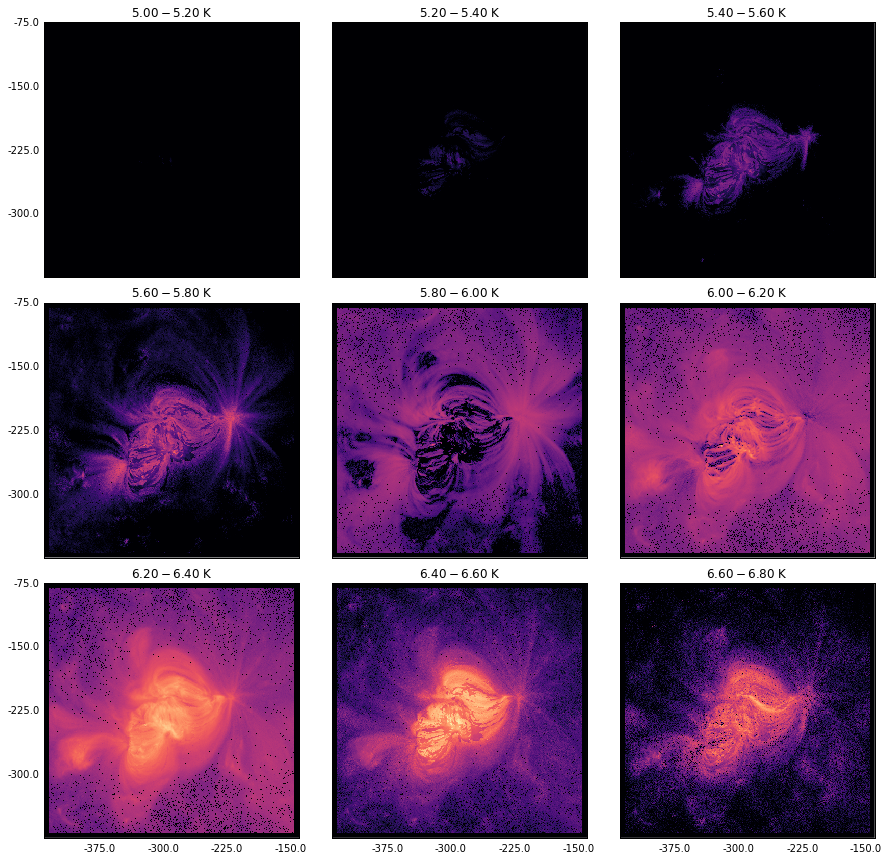

In [16]:
fig = plt.figure(figsize=(15,15))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
for i in range(len(hk_model.temperature)-1):
    tmp = em[i]
    ax = fig.add_subplot(3,3,i+1,projection=tmp)
    tmp.plot(annotate=False,title=False,axes=ax,norm=matplotlib.colors.SymLogNorm(1,vmin=1e25,vmax=1e29))
    ax.grid(alpha=0)
    lon = ax.coords[0]
    lat = ax.coords[1]
    lon.set_ticks_visible(False)
    lat.set_ticks_visible(False)
    if i%3 != 0:
        lat.set_ticklabel_visible(False)
    if i < 6:
        lon.set_ticklabel_visible(False)
    ax.set_title(f'${np.log10(tmp.meta["temp_a"]):.2f}-{np.log10(tmp.meta["temp_b"]):.2f}$ K')

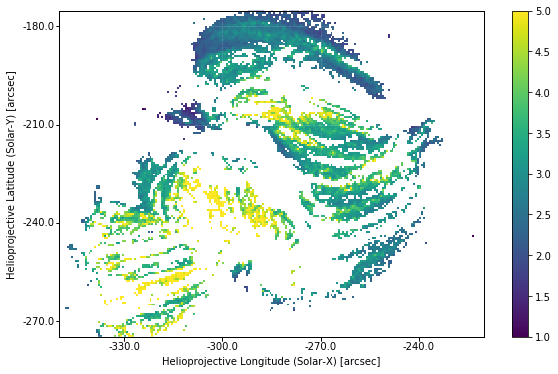

In [21]:
slope_map = em.make_slope_map(temperature_bounds=[0.8,3.25]*u.MK,em_threshold=1e18*u.cm**-5,rsquared_tolerance=0.9)
slope_map = sunpy.map.Map(np.where(slope_map.data == 0, np.nan, slope_map.data),slope_map.meta)
slope_map = slope_map.submap(SkyCoord(Tx=-350*u.arcsec,Ty=-275*u.arcsec,frame=slope_map.coordinate_frame),
                             SkyCoord(Tx=-220*u.arcsec,Ty=-175*u.arcsec,frame=slope_map.coordinate_frame))
fig = plt.figure(figsize=(10,6))
ax = fig.gca(projection=slope_map)
im = slope_map.plot(axes=ax,cmap='viridis',vmin=1,vmax=5,title=False)
fig.colorbar(im,ax=ax)

/Users/willbarnes/anaconda/envs/synthesized-timelags/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


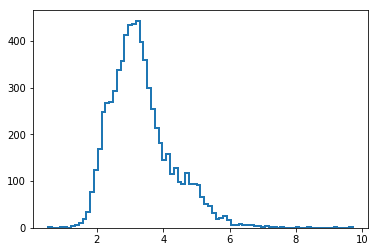

In [24]:
flat_slopes = slope_map.data.flatten()
plt.hist(flat_slopes[flat_slopes > 0],bins='fd',histtype='step',lw=2);

## Cheung Sparse Model

In [180]:
class CheungModel(IDLModel):
    
    @property
    def ssw_packages(self,):
        return ['sdo/aia','hinode/xrt']
    
    @property
    def ssw_paths(self,):
        return ['aia','xrt']
    
    @property
    def input_args(self,):
        d = Time(self.maps[0].date).tai.datetime
        return {'maps': self.mapcube.T.tolist(),
                'response_matrix': self.response_matrix.tolist(),
                'aia_error_table_filename': '/Users/willbarnes/ssw/sdo/aia/response/aia_V2_error_table.txt',
                'n_sample': 1,
                'log_temperature': np.log10(((self.temperature[1:] + self.temperature[:-1])/2.).to(u.K).value).tolist(),
                'date': f'{d.year}-{d.month:02d}-{d.day:02d}T{d.hour:02d}:{d.minute:02d}:{d.second:02d}.{int(d.microsecond/1e4):02d}',
                'exposure_times': f"[{','.join([f'{m.exposure_time.to(u.s).value}' for m in self.maps])}]",
                'tolerance_factor': 1.4,
               }
    
    @property
    def save_vars(self,):
        return ['emcube']
    
    def fit(self,):
        self.results = self._fit()
        em = np.transpose(self.results['emcube'],axes=(2,1,0))/(u.cm**5)/u.K
        em = em*1e26
        return self.to_emcube(em)
    
    @property
    def _template(self,):
        return """
data = {{maps}}
response_matrix = {{response_matrix}}
log_temperature = {{log_temperature}}
aia_sparse_em_init, timedepend='{{date}}', /evenorm, use_lgtaxis=log_temperature, bases_sigmas=[0.0,0.1,0.2] ;,use_tresp=response_matrix
;lgtaxis = aia_sparse_em_lgtaxis()
exptimestr = '{{exposure_times}}'
common_errtable=aia_bp_read_error_table('{{aia_error_table_filename}}')
tolfunc = 'aia_bp_estimate_error(y*'+exptimestr+', [94,131,171,193,211,335], num_images={{n_sample}})/'+exptimestr
aia_sparse_em_solve, data, tolfunc=tolfunc, tolfac={{tolerance_factor}}, oem=emcube, status=status, coeff=coeff"""

In [181]:
cheung = CheungModel(maps, temperature_bin_edges, responses, 
                     dem_path='/Users/willbarnes/Documents/work/codes/cheung_dem/')

In [165]:
with open('/Users/willbarnes/Desktop/cheung_foo.pro','w') as f:
    f.write(cheung.ssw.custom_script(cheung._template, cheung.input_args))

In [182]:
em_cheung = cheung.fit()

SSWIDLError: IDL Version 8.5, Mac OS X (darwin x86_64 m64).
(c) 2015, Exelis Visual Information Solutions, Inc., a subsidiary of Harris Corporation.
Installation number: 401801-1.
Licensed for use by: Rice University

% Compiled module: SSW_PATH.
% Compiled module: SSW_INSTRUMENTS.
% Compiled module: WC_WHERE.
% Compiled module: PATHFIX.
% Compiled module: UNIQO.
% Compiled module: STRJUSTIFY.
% Compiled module: UNIQ.
% Compiled module: DEFAULT.
% Compiled module: PRSTR.
% SSW_PATH: Number of paths changed from 91 to 106
% Compiled module: HISSW_PROCEDURE.
% Compiled module: AIA_SPARSE_EM_INIT.
% Compiled module: AIA_GET_RESPONSE.
% Compiled module: RESTGEN.
% Compiled module: FILE2TIME.
% Compiled module: EXTRACT_FID.
% Compiled module: BREAK_FILE.
% Compiled module: EXTRACT_FIDS.
% Compiled module: DELVARX.
% Compiled module: DELVARX2.
% Compiled module: DESTROY.
% Compiled module: STRMIDS.
% Compiled module: STRSPECIAL.
% Compiled module: STRLASTCHAR.
% Compiled module: ANYTIM.
% Compiled module: IS_STRUCT.
% Compiled module: CHECKVAR.
% Compiled module: STR2UTC.
% Compiled module: VALID_NUM.
% Compiled module: BOOST_ARRAY.
% Compiled module: UTC2INT.
% Compiled module: TAG_EXIST.
% Compiled module: DATE2MJD.
% Compiled module: CHECK_INT_TIME.
% Compiled module: GET_LEAP_SEC.
% Compiled module: UTIME2STR.
% Compiled module: GETUTBASE.
% Compiled module: GETUT.
% Compiled module: INT2EX.
% Compiled module: DAYCNV.
% Compiled module: EX2INT.
% Compiled module: JDCNV.
% Compiled module: INT2UTC.
% Compiled module: MJD2DATE.
% Compiled module: UTC2STR.
% Compiled module: ANYTIM2TAI.
% Compiled module: ANYTIM2UTC.
% Compiled module: UTC2TAI.
% Compiled module: AIA_BP_READ_RESPONSE_TABLE.
% Compiled module: RD_TFILE.
% Compiled module: RELTIME.
% Compiled module: UT_TIME.
% Compiled module: UT_DIFF.
% Compiled module: SYSTIM.
% Compiled module: INT2SEC.
% Compiled module: ANYTIM2INTS.
% Compiled module: TIMSTR2EX.
% Compiled module: CHECK_TIME.
% Compiled module: FMT_TIM.
% Compiled module: GT_DAY.
% Compiled module: GT_TIME.
% Compiled module: ATIME.
% Compiled module: FCHECK.
% Compiled module: F_ATIME.
% Compiled module: TIMEGRID.
% Compiled module: CONCAT_STRUCT.
% Compiled module: INT2SECARR.
% Compiled module: BOX_MESSAGE.
% Compiled module: AIA_BP_BLEND_CHANNELS.
% Compiled module: AIA_BP_PARSE_EFFAREA.
% Compiled module: AIA_BP_UTC2DATE_STRING.
% Compiled module: AIA_BP_CORRECTIONS.
% Compiled module: INTERPOL.
% Compiled module: STR_SUBSET.
% Compiled module: IS_NUMBER.
% Compiled module: AIA_BP_AREA2TRESP.
% Compiled module: AIA_BP_DATE_STRING.
% Compiled module: BIN_DATE.
% Compiled module: AIA_BP_MAKE_TRESP.
% Compiled module: LIMITS.
% Compiled module: AIA_BP_PARSE_TRESP.
% Compiled module: AIA_BP_READ_ERROR_TABLE.
% Compiled module: AIA_BP_ESTIMATE_ERROR.
% Illegal variable attribute: WAVELNTH.
% Variable is undefined: TOL.
% Execution halted at: AIA_SPARSE_EM_SOLVE  394
   /Users/willbarnes/ssw/sdo/aia/idl/util/aia_sparse_em_init.pro
%                      HISSW_PROCEDURE    12
   /var/folders/wz/hhl6rk5s76bfmczhttkt8vbr0000gn/T/tmpxky12yu0/idl_procedure
  _20180708-024447.pro
%                      $MAIN$          


## Sandbox

In [33]:
f"[{','.join([f'{m.exposure_time.to(u.s).value}' for m in maps])}]"

'[2.901051,2.901311,2.000197,1.999629,2.901278,2.900791]'

In [78]:
'T'.join(str(Time(maps[0].date,format='datetime',precision=0,out_subfmt='tai').tai).split())

'2011-02-12T12:00:36.120000'

In [91]:
foo = Time(maps[0].date,)

In [92]:
foo

<Time object: scale='utc' format='datetime' value=2011-02-12 12:00:02.120000>

In [93]:
foo.precision = 0

In [97]:
dt = maps[0].date

In [99]:
footai = foo.tai.datetime

In [106]:
f'{footai.month:02d}'

'02'

In [95]:
foo.tai

<Time object: scale='tai' format='datetime' value=2011-02-12 12:00:36.120000>

In [96]:
foo.datetime

datetime.datetime(2011, 2, 12, 12, 0, 2, 120000)

In [89]:
maps[0].date

datetime.datetime(2011, 2, 12, 12, 0, 2, 120000)

In [125]:
f'{int(footai.microsecond/1e4):02d}'

'12'

In [132]:
int((footai.microsecond*u.microsecond).to(u.centisecond).value)

11